In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dense, BatchNormalization
from sklearn.model_selection import train_test_split


2024-05-21 08:37:18.161073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 08:37:18.161201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 08:37:18.260045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Importing Dataset**

In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [3]:
from sklearn.utils import shuffle
data = shuffle(data)

In [4]:
data['sentiment'][data['sentiment']==4]=1

/tmp/ipykernel_34/2849171170.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['sentiment'][data['sentiment']==4]=1
/tmp/ipykernel_34/2849171170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [5]:
text = list(data['text'])
label = list(data['sentiment'])

In [6]:
text = text[:130000]
label = label[:130000]

In [9]:
from collections import Counter

# Count occurrences of each class
class_counts = Counter(label)

# Print the counts of each class
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} occurrences")

Class '0': 64859 occurrences
Class '1': 65141 occurrences


In [10]:
traning_text, testing_text, traning_labels, testing_labels = train_test_split(text,label, test_size=0.2,random_state=7)

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Preproessing Dataset**

In [12]:
def prepocessing(text, stopWords = set(stopwords.words('english')),unique_words_option=True):
    text=text.lower()
    text=text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\w*\d\w*' , ' ' , text)
    text = re.sub(r'[0-9]' , ' ' , text)
    text = re.sub(r'[^a-zA-Z0-9\s]' , ' ' , text)
    text = re.sub(r'\s+' , ' ', text)
    text = word_tokenize(text)
    text = [i for i in text if i != '']
    text = [i for i in text if i not in stopWords]
    unique_words= set(text)
    unique_words = [word for word in unique_words if len(word) > 3]
    return unique_words

In [13]:
traning_words = []
for i in traning_text :
    traning_words.append( prepocessing(str(i)))

In [14]:
traning_words[:5]

[['wake', 'almost', 'accidental', 'midnight'],
 ['dont',
  'wasnt',
  'jesus',
  'post',
  'code',
  'made',
  'retweeted',
  'laugh',
  'worry',
  'subliminal'],
 ['grumps', 'shaun'],
 [],
 ['moments',
  'really',
  'designing',
  'billboard',
  'watchcam',
  'change',
  'poetic',
  'caseproduct',
  'quotseasons',
  'lastquot',
  'thinks',
  'slogan',
  'garden']]

In [15]:
max_length = max(len(sublist) for sublist in traning_words)
print(max_length)

18


In [16]:
testing_words = []
for i in testing_text :
    testing_words.append( prepocessing(str(i)))

In [17]:
test_max_length = max(len(sublist) for sublist in testing_words)
print(test_max_length)

17


**Get WordEmbeddings Of Words Using Pretrained FastText Model**

In [18]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
! gunzip "cc.en.300.bin.gz"

--2024-05-21 08:40:37--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.11, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: 'cc.en.300.bin.gz'

cc.en.300.bin.gz    100%[===================>]   4.19G   311MB/s    in 13s     

2024-05-21 08:40:51 (325 MB/s) - 'cc.en.300.bin.gz' saved [4503593528/4503593528]



In [19]:
from gensim.models.fasttext import load_facebook_model
pre_model=load_facebook_model('/kaggle/working/cc.en.300.bin')

In [20]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
training_embedded_sequences = []
for text in traning_words:
    embedded_sequence = [pre_model.wv[word] for word in text]
    training_embedded_sequences.append(embedded_sequence)
training_padded_sequences = pad_sequences(training_embedded_sequences, maxlen=18, padding='post', truncating='post', dtype='float32')


In [21]:
testing_embedded_sequences = []
for text in testing_words:
    embedded_sequence = [pre_model.wv[word] for word in text]
    testing_embedded_sequences.append(embedded_sequence)
testing_padded_sequences = pad_sequences(testing_embedded_sequences, maxlen=18, padding='post', truncating='post', dtype='float32')


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, concatenate, Dense, BatchNormalization, Dropout

filters = 265
kernel_sizes = [2,3,5]
input_length = 18  # Length of each input sequence
embedding_dim = 300  # Dimensionality of word embeddings

inputs = Input(shape=(input_length, embedding_dim))  
conv_layers = []
for kernel_size in kernel_sizes:
    conv_layer = Conv1D(filters, kernel_size, activation='relu')(inputs)
    conv_layer = Dropout(0.5)(conv_layer)
    conv_layer = BatchNormalization()(conv_layer)
    pooled_layer = GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pooled_layer)

concatenated = concatenate(conv_layers, axis=1)
output_layer = Dense(1, activation='sigmoid')(concatenated)  

model = Model(inputs=inputs, outputs=output_layer)

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
model.fit(training_padded_sequences, np.array(traning_labels), epochs=10, batch_size=128, validation_data=(testing_padded_sequences, np.array(testing_labels)))

Epoch 1/10
 19/813 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6061 - loss: 1.2195  

I0000 00:00:1716281123.616388     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


813/813 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.6802 - loss: 0.7613 - val_accuracy: 0.7420 - val_loss: 0.5301
Epoch 2/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7477 - loss: 0.5152 - val_accuracy: 0.7448 - val_loss: 0.5213
Epoch 3/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7590 - loss: 0.4952 - val_accuracy: 0.7339 - val_loss: 0.5316
Epoch 4/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7738 - loss: 0.4749 - val_accuracy: 0.7455 - val_loss: 0.5147
Epoch 5/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7879 - loss: 0.4519 - val_accuracy: 0.7314 - val_loss: 0.5355
Epoch 6/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7978 - loss: 0.4333 - val_accuracy: 0.7411 - val_loss: 0.5257
Epoch 7/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8134 - loss: 0.4068 - val_accuracy: 0.7335 - val_loss: 0.5419
Epoch 8/10
813/813 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8285 - loss: 0.3822 - val_accuracy: 0.7220 - va

In [24]:
y_pred = model.predict(testing_padded_sequences)

813/813 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [25]:
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

In [26]:
from sklearn.metrics import classification_report
target_names =  ['Negative', 'Positive']
print(classification_report(testing_labels, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.72      0.76      0.74     12947
    Positive       0.75      0.71      0.73     13053

    accuracy                           0.73     26000
   macro avg       0.73      0.73      0.73     26000
weighted avg       0.73      0.73      0.73     26000



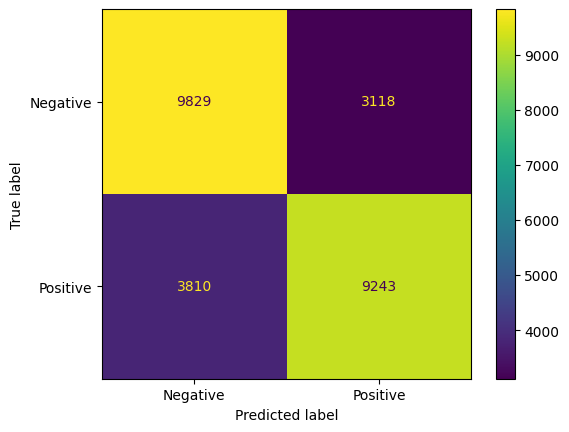

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
confusion_matrix = confusion_matrix(testing_labels, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])

cm_display.plot()
plt.show()

In [30]:
def sentimentAnalysisModule(input_layer):
    conv1 = Conv1D(32, 2, activation='relu')(input_layer)
    conv1 = Dropout(0.5)(conv1)
    conv1 = BatchNormalization()(conv1)
    maxpool1 = GlobalMaxPooling1D()(conv1)
    
    conv2 = Conv1D(64,3, activation='relu')(input_layer)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    maxpool2 = GlobalMaxPooling1D()(conv2)

    conv3 = Conv1D(128,4, activation='relu')(input_layer)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    maxpool3 = GlobalMaxPooling1D()(conv3)

    conv4 = Conv1D(128,6, activation='relu')(input_layer)
    conv4 = Dropout(0.5)(conv4)
    conv4 = BatchNormalization()(conv4)
    maxpool4 = GlobalMaxPooling1D()(conv4)
    
    conv5 = Conv1D(128,10, activation='relu')(input_layer)
    conv5 = Dropout(0.5)(conv5)
    conv5 = BatchNormalization()(conv5)
    maxpool5 = GlobalMaxPooling1D()(conv5)
    
    conv6 = Conv1D(265, 3, activation='relu')(input_layer)
    conv6 = Dropout(0.5)(conv6)
    conv6 = BatchNormalization()(conv6)
    maxpool6 = GlobalMaxPooling1D()(conv6)

    conv7 = Conv1D(128, 7, activation='relu')(input_layer)
    conv7 = Dropout(0.5)(conv7)
    conv7 = BatchNormalization()(conv7)
    maxpool7 = GlobalMaxPooling1D()(conv7)
    
    concatenated = concatenate([maxpool1, maxpool2, maxpool3, maxpool4, maxpool5,maxpool6,maxpool7], axis=-1)
    output = Dense(1, activation='sigmoid')(concatenated)
    
    return output

In [31]:
embedding_dim = 300
input_length = 18
input_tensor = Input(shape=(input_length, embedding_dim))
output = sentimentAnalysisModule(input_tensor)
model2 = Model(inputs=input_tensor, outputs=output)

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
model2.fit(training_padded_sequences, np.array(traning_labels), epochs=5, batch_size=128, validation_data=(testing_padded_sequences, np.array(testing_labels)))

Epoch 1/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 45s 32ms/step - accuracy: 0.6836 - loss: 0.7471 - val_accuracy: 0.7257 - val_loss: 0.5456
Epoch 2/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7476 - loss: 0.5159 - val_accuracy: 0.7410 - val_loss: 0.5242
Epoch 3/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7674 - loss: 0.4856 - val_accuracy: 0.7405 - val_loss: 0.5208
Epoch 4/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7831 - loss: 0.4604 - val_accuracy: 0.7399 - val_loss: 0.5211
Epoch 5/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7987 - loss: 0.4308 - val_accuracy: 0.7371 - val_loss: 0.5302


In [32]:
y_pred2 = model2.predict(testing_padded_sequences)

813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [33]:
threshold = 0.5
y_pred2 = (y_pred2 >= threshold).astype(int)

In [34]:
from sklearn.metrics import classification_report
target_names =  ['Negative', 'Positive']
print(classification_report(testing_labels, y_pred2, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.75      0.71      0.73     12947
    Positive       0.73      0.77      0.75     13053

    accuracy                           0.74     26000
   macro avg       0.74      0.74      0.74     26000
weighted avg       0.74      0.74      0.74     26000



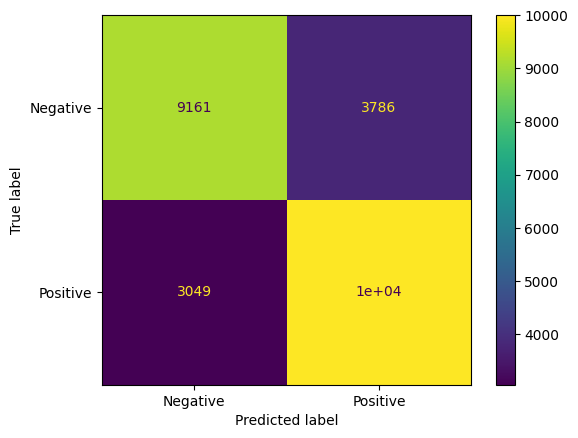

In [35]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
confusion_matrix = confusion_matrix(testing_labels, y_pred2)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])

cm_display.plot()
plt.show()

In [36]:
from tensorflow.keras import layers, models
embedding_dim = 300
input_length = 18
model3 = models.Sequential()

model3.add(layers.Conv1D(filters = 64, kernel_size =3, activation='relu', strides = 1, padding='same',input_shape=(input_length, embedding_dim)))
model3.add(layers.Conv1D(filters = 64, kernel_size =3, activation='relu', strides = 1, padding='same'))
model3.add(layers.MaxPooling1D(2 , strides = 2))

model3.add(layers.Conv1D(filters = 128, kernel_size =3, activation='relu', strides = 1, padding='same'))
model3.add(layers.Conv1D(filters = 128, kernel_size =3, activation='relu', strides = 1, padding='same'))
model3.add(layers.MaxPooling1D(2 , strides = 2))

model3.add(layers.Conv1D(filters = 256, kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.Conv1D(filters = 256,  kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.Conv1D(filters = 256,  kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.MaxPooling1D(2 , strides = 2))

model3.add(layers.Conv1D(filters = 512, kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.Conv1D(filters = 512,  kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.Conv1D(filters = 512,  kernel_size =3, activation='relu',strides = 1, padding='same'))
model3.add(layers.MaxPooling1D(2 , strides = 2, padding='same'))

model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(84, activation='relu'))
model3.add(layers.Dense(units=1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [37]:
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  
model3.fit(training_padded_sequences, np.array(traning_labels), epochs=5, batch_size=128, validation_data=(testing_padded_sequences, np.array(testing_labels)))

Epoch 1/5
 21/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.5064 - loss: 0.6935

W0000 00:00:1716281436.523811     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


813/813 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6760 - loss: 0.5896

W0000 00:00:1716281446.884181     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1716281448.966229     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


813/813 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.6760 - loss: 0.5896 - val_accuracy: 0.7347 - val_loss: 0.5406
Epoch 2/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7535 - loss: 0.5063 - val_accuracy: 0.7482 - val_loss: 0.5122
Epoch 3/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7713 - loss: 0.4802 - val_accuracy: 0.7503 - val_loss: 0.5191
Epoch 4/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7858 - loss: 0.4554 - val_accuracy: 0.7404 - val_loss: 0.5145
Epoch 5/5
813/813 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8002 - loss: 0.4335 - val_accuracy: 0.7455 - val_loss: 0.5399


In [38]:
y_pred3 = model3.predict(testing_padded_sequences)

813/813 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [39]:
threshold = 0.5
y_pred3 = (y_pred3 >= threshold).astype(int)

In [40]:
from sklearn.metrics import classification_report
target_names =  ['Negative', 'Positive']
print(classification_report(testing_labels, y_pred3, target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.77      0.70      0.73     12947
    Positive       0.73      0.79      0.76     13053

    accuracy                           0.75     26000
   macro avg       0.75      0.75      0.74     26000
weighted avg       0.75      0.75      0.74     26000



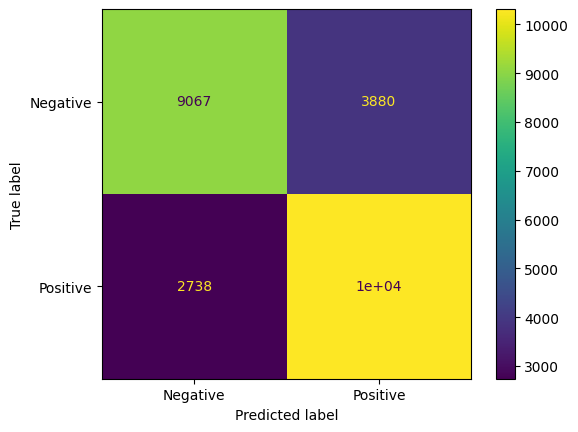

In [41]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
confusion_matrix = confusion_matrix(testing_labels, y_pred3)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Negative', 'Positive'])

cm_display.plot()
plt.show()

**Select 10 random sentences from the test dataset and print both Y_pred and Y_Test for each sentence in the document**

In [ ]:
data = []
for i in range(5):
    data.append((testing_text[i],testing_labels[i],y_pred2[i]))
df = pd.DataFrame(data, columns = ['Text','Sentiment','Predicted Sentiment'])
df = df.replace([0,1], ["Negative","Positive"])
print(df.head())

**Select 10 random indices then extract the selected sentences and their true labels**

In [46]:
import random
random.seed(42)

random_indices = random.sample(range(len(testing_text)), 10)

selected_sentences = [testing_text[i] for i in random_indices]
true_labels = [testing_labels[i] for i in random_indices]

**preprocess the selected sentences**

In [47]:
words = []
for i in selected_sentences :
    words.append( prepocessing(str(i)))

**Get Words embeddings**

In [52]:
embedded_sequences = []
for text in words:
    embedded_sequence = [pre_model.wv[word] for word in text]
    embedded_sequences.append(embedded_sequence)
padded_sequences = pad_sequences(testing_embedded_sequences, maxlen=18, padding='post', truncating='post', dtype='float32')


**Predict the selected sentences**

In [53]:
y_pred = model3.predict(padded_sequences)

813/813 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [55]:
threshold = 0.5
y_pred = (y_pred >= threshold).astype(int)

In [58]:
data = []
for i in range(10):
    data.append((selected_sentences[i],true_labels[i],y_pred[i]))
df = pd.DataFrame(data, columns = ['Text','True Sentiment','Predicted Sentiment'])
df = df.replace([0,1], ["Negative","Positive"])
print(df.head())

                                                Text True Sentiment  \
0  Having a huge family dinner but why do I have ...       Negative   
1  goin 2 the BX today wit the fam, my grandparen...       Negative   
2  Can't believe I have to go to work 2morro. 3 w...       Negative   
3                                 IPOD DEATH. R.I.P        Negative   
4  @_supernatual_ Give me some Dean tied up Pron,...       Positive   

  Predicted Sentiment  
0            Negative  
1            Positive  
2            Negative  
3            Negative  
4            Negative  


In [57]:
for i in range(10):
    print(selected_sentences[i],true_labels[i],y_pred[i])

Having a huge family dinner but why do I have to kiss every1  0 [0]
goin 2 the BX today wit the fam, my grandparents wanna stay there the duration of their trip  i dont want them to 0 [1]
Can't believe I have to go to work 2morro. 3 weeks off was not enough!  0 [0]
IPOD DEATH. R.I.P  0 [0]
@_supernatual_ Give me some Dean tied up Pron, Dean or Sam shirtless pron, hmmm....Some Jo maybe b/c she's hot.  I'll think of more.  1 [0]
@audreyjrs Yo! I have a new phone new # no BBM  I'm having buyers remorse. 0 [0]
so cold outside in thatcham  cant wait until next week when its supposd to get hot, bring on the british summer! ha 0 [1]
just finished music assignment  relieved 1 [1]
@sweetshakiral thanks .. glad you like the range  1 [1]
Sometimes orange juice isn't as orange as you'd think it would be..  1 [0]
